<a href="https://colab.research.google.com/github/Hjhirp/Tweet-Topic-Modelling/blob/main/Notebook/AUS_LDA_SENTIMENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Importing Libraries </h1>

In [ ]:
!pip install pyLDAvis

In [ ]:
#!wget https://github.com/bhushaaan/omdena_aus/blob/916166635c829f40d2e8d7428fb743e29af71d19/Twitterabuse.csv

In [ ]:
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#1introduction
import numpy as np
import pandas as pd
import json
import glob

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import nltk
nltk.download('stopwords')

import gensim
from gensim.corpora import Dictionary

from IPython.display import clear_output

import pyLDAvis.gensim_models as gensim_models
from gensim.models.coherencemodel import CoherenceModel

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


<h1> Preparing data and storing in df dataframe </h1>

In [ ]:
df = pd.read_csv('Twitterabuse.csv', error_bad_lines=False, engine="python", encoding="ISO-8859-1")
#df = pd.read_csv("temp.csv", sep=";")
df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,conversationId,lang,source,sourceUrl,sourceLabel,outlinks,tcooutlinks,media,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags
0,0,https://twitter.com/martyps/status/14766877858...,2021-12-30 22:52:58+00:00,@TrakkyD @NSWHealth abuse was hurled at scient...,@TrakkyD @NSWHealth abuse was hurled at scient...,1476687785872420864,"{'username': 'martyps', 'id': 17335098, 'displ...",0,0,0,0,1476674512187846665,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,NaN,NaN,NaN,NaN,NaN,1.476685e+18,"{'username': 'TrakkyD', 'id': 1137233693548748...","[{'username': 'TrakkyD', 'id': 113723369354874...","{'longitude': 150.520928608, 'latitude': -34.1...","{'fullName': 'Sydney, New South Wales', 'name'...",NaN,NaN
1,1,https://twitter.com/AlliC19/status/14766814294...,2021-12-30 22:27:42+00:00,@crakeka1 It is interesting as many attack oth...,@crakeka1 It is interesting as many attack oth...,1476681429400449034,"{'username': 'AlliC19', 'id': 1903049988, 'dis...",1,0,1,0,1476676731851329536,en,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,NaN,NaN,NaN,NaN,NaN,1.476677e+18,"{'username': 'crakeka1', 'id': 2723185873, 'di...","[{'username': 'crakeka1', 'id': 2723185873, 'd...","{'longitude': 144.593741856, 'latitude': -38.4...","{'fullName': 'Melbourne, Victoria', 'name': 'M...",NaN,NaN
2,2,https://twitter.com/mikjcal/status/14766793839...,2021-12-30 22:19:35+00:00,@chadfelixg No wonder LGBTQ would feel mentall...,@chadfelixg No wonder LGBTQ would feel mentall...,1476679383964217352,"{'username': 'mikjcal', 'id': 8096509038001561...",0,0,1,0,1476676718610030598,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,NaN,NaN,NaN,NaN,NaN,1.476677e+18,"{'username': 'chadfelixg', 'id': 17626317, 'di...","[{'username': 'chadfelixg', 'id': 17626317, 'd...","{'longitude': 144.593741856, 'latitude': -38.4...","{'fullName': 'Melbourne, Victoria', 'name': 'M...",NaN,NaN
3,3,https://twitter.com/AweCentiQue/status/1476483...,2021-12-30 09:20:47+00:00,@thesayno7 @Anne_Ruston @JElliotMP @JulianHill...,@thesayno7 @Anne_Ruston @JElliotMP @JulianHill...,1476483394041090051,"{'username': 'AweCentiQue', 'id': 140039824775...",0,1,1,0,1450303683481116680,en,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,NaN,NaN,NaN,NaN,NaN,1.450824e+18,"{'username': 'thesayno7', 'id': 11853666428694...","[{'username': 'thesayno7', 'id': 1185366642869...","{'longitude': 152.668522848, 'latitude': -27.7...","{'fullName': 'Brisbane, Queensland', 'name': '...",NaN,NaN
4,4,https://twitter.com/Kuvlotik/status/1476424899...,2021-12-30 05:28:21+00:00,@marie19705 @ScottMorrisonMP 2/\ndivides inste...,@marie19705 @ScottMorrisonMP 2/\ndivides inste...,1476424899249926145,"{'username': 'Kuvlotik', 'id': 93730228, 'disp...",1,0,1,0,1476116833002409984,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,NaN,NaN,NaN,NaN,NaN,1.476422e+18,"{'username': 'Kuvlotik', 'id': 93730228, 'disp...","[{'username': 'marie19705', 'id': 48946651, 'd...","{'longitude': 151.468376, 'latitude': -30.6589...","{'fullName': 'Uralla, New South Wales', 'name'...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,https://twitter.com/Michael61058663/status/147...,2021-12-20 18:36:09+00:00,@ToniC8 Taking cheap shots is basically gutles...,@ToniC8 Taking cheap shots is basically gutles...,1472999277899120640,"{'username': 'Michael61058663', 'id': 14281003...",0,0,1,0,1472972372210819079,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,NaN,

<h1> Finding Null values </h1>

In [ ]:
df.isnull().sum()

Unnamed: 0            0
url                   0
date                  0
content               0
renderedContent       0
id                    0
user                  0
replyCount            0
retweetCount          0
likeCount             0
quoteCount            0
conversationId        0
lang                  0
source                0
sourceUrl             0
sourceLabel           0
outlinks             76
tcooutlinks          76
media                93
retweetedTweet      100
quotedTweet          85
inReplyToTweetId     38
inReplyToUser        38
mentionedUsers       38
coordinates           0
place                 0
hashtags             91
cashtags            100
dtype: int64

In [ ]:
df = df.drop(['Unnamed: 0','id','conversationId','inReplyToTweetId','inReplyToUser','mentionedUsers','cashtags','hashtags','sourceLabel','inReplyToTweetId'], axis= 'columns')
df = df.drop(['sourceUrl','source'], axis = 'columns')
df.head()

,url,date,content,renderedContent,user,replyCount,retweetCount,likeCount,quoteCount,lang,outlinks,tcooutlinks,media,retweetedTweet,quotedTweet,coordinates,place
0,https://twitter.com/martyps/status/14766877858...,2021-12-30 22:52:58+00:00,@TrakkyD @NSWHealth abuse was hurled at scient...,@TrakkyD @NSWHealth abuse was hurled at scient...,"{'username': 'martyps', 'id': 17335098, 'displ...",0,0,0,0,en,NaN,NaN,NaN,NaN,NaN,"{'longitude': 150.520928608, 'latitude': -34.1...","{'fullName': 'Sydney, New South Wales', 'name'..."
1,https://twitter.com/AlliC19/status/14766814294...,2021-12-30 22:27:42+00:00,@crakeka1 It is interesting as many attack oth...,@crakeka1 It is interesting as many attack oth...,"{'username': 'AlliC19', 'id': 1903049988, 'dis...",1,0,1,0,en,NaN,NaN,NaN,NaN,NaN,"{'longitude': 144.593741856, 'latitude': -38.4...","{'fullName': 'Melbourne, Victoria', 'name': 'M..."
2,https://twitter.com/mikjcal/status/14766793839...,2021-12-30 22:19:35+00:00,@chadfelixg No wonder LGBTQ would feel mentall...,@chadfelixg No wonder LGBTQ would feel mentall...,"{'username': 'mikjcal', 'id': 8096509038001561...",0,0,1,0,en,NaN,NaN,NaN,NaN,NaN,"{'longitude': 144.593741856, 'latitude': -38.4...","{'fullName': 'Melbourne, Victoria', 'name': 'M..."
3,https://twitter.com/AweCentiQue/status/1476483...,2021-12-30 09:20:47+00:00,@thesayno7 @Anne_Ruston @JElliotMP @JulianHill...,@thesayno7 @Anne_Ruston @JElliotMP @JulianHill...,"{'username': 'AweCentiQue', 'id': 140039824775...",0,1,1,0,en,NaN,NaN,NaN,NaN,NaN,"{'longitude': 152.668522848, 'latitude': -27.7...","{'fullName': 'Brisbane, Queensland', 'name': '..."
4,https://twitter.com/Kuvlotik/status/1476424899...,2021-12-30 05:28:21+00:00,@marie19705 @ScottMorrisonMP 2/\ndivides inste...,@marie19705 @ScottMorrisonMP 2/\ndivides inste...,"{'username': 'Kuvlotik', 'id': 93730228, 'disp...",1,0,1,0,en,NaN,NaN,NaN,NaN,NaN,"{'longitude': 151.468376, 'latitude': -30.6589...","{'fullName': 'Uralla, New South Wales', 'name'..."


In [ ]:
#df1 = df.dropna(inplace =True)
#df1
df

,url,date,content,renderedContent,user,replyCount,retweetCount,likeCount,quoteCount,lang,outlinks,tcooutlinks,media,retweetedTweet,quotedTweet,coordinates,place
0,https://twitter.com/martyps/status/14766877858...,2021-12-30 22:52:58+00:00,@TrakkyD @NSWHealth abuse was hurled at scient...,@TrakkyD @NSWHealth abuse was hurled at scient...,"{'username': 'martyps', 'id': 17335098, 'displ...",0,0,0,0,en,NaN,NaN,NaN,NaN,NaN,"{'longitude': 150.520928608, 'latitude': -34.1...","{'fullName': 'Sydney, New South Wales', 'name'..."
1,https://twitter.com/AlliC19/status/14766814294...,2021-12-30 22:27:42+00:00,@crakeka1 It is interesting as many attack oth...,@crakeka1 It is interesting as many attack oth...,"{'username': 'AlliC19', 'id': 1903049988, 'dis...",1,0,1,0,en,NaN,NaN,NaN,NaN,NaN,"{'longitude': 144.593741856, 'latitude': -38.4...","{'fullName': 'Melbourne, Victoria', 'name': 'M..."
2,https://twitter.com/mikjcal/status/14766793839...,2021-12-30 22:19:35+00:00,@chadfelixg No wonder LGBTQ would feel mentall...,@chadfelixg No wonder LGBTQ would feel mentall...,"{'username': 'mikjcal', 'id': 8096509038001561...",0,0,1,0,en,NaN,NaN,NaN,NaN,NaN,"{'longitude': 144.593741856, 'latitude': -38.4...","{'fullName': 'Melbourne, Victoria', 'name': 'M..."
3,https://twitter.com/AweCentiQue/status/1476483...,2021-12-30 09:20:47+00:00,@thesayno7 @Anne_Ruston @JElliotMP @JulianHill...,@thesayno7 @Anne_Ruston @JElliotMP @JulianHill...,"{'username': 'AweCentiQue', 'id': 140039824775...",0,1,1,0,en,NaN,NaN,NaN,NaN,NaN,"{'longitude': 152.668522848, 'latitude': -27.7...","{'fullName': 'Brisbane, Queensland', 'name': '..."
4,https://twitter.com/Kuvlotik/status/1476424899...,2021-12-30 05:28:21+00:00,@marie19705 @ScottMorrisonMP 2/\ndivides inste...,@marie19705 @ScottMorrisonMP 2/\ndivides inste...,"{'username': 'Kuvlotik', 'id': 93730228, 'disp...",1,0,1,0,en,NaN,NaN,NaN,NaN,NaN,"{'longitude': 151.468376, 'latitude': -30.6589...","{'fullName': 'Uralla, New South Wales', 'name'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,https://twitter.com/Michael61058663/status/147...,2021-12-20 18:36:09+00:00,@ToniC8 Taking cheap shots is basically gutles...,@ToniC8 Taking cheap shots is basically gutles...,"{'username': 'Michael61058663', 'id': 14281003...",0,0,1,0,en,NaN,NaN,NaN,NaN,NaN,"{'longitude': 138.44212992, 'latitude': -35.34...","{'fullName': 'Adelaide, South Australia', 'nam..."
96,https://twitter.com/reoreilly1/status/14729881...,2021-12-20 17:51:47+00:00,@TheblueTake @thereminfan @DLulabele Donât 2...,@TheblueTake @thereminfan @DLulabele Donât 2...,"{'username': 'reoreilly1', 'id': 9214869766073...",0,0,2,0,en,NaN,NaN,NaN,NaN,NaN,"{'longitude': 150.520928608, 'latitude': -34.1...","{'fullName': 'Sydney, New South Wales', 'name'..."
97,https://twitter.com/AnnikaCorbert/status/14728...,2021-12-20 10:57:50+00:00,Of course Right wing parties will funnel votes...,Of course Right wing parties will funnel votes...,"{'username': 'AnnikaCorbert', 'id': 2761178294...",1,1,0,0,en,['https://twitter.com/PRGuy17/status/147281915...,['https://t.co/VFrDz2jzcg'],NaN,NaN,{'url': 'https://twitter.com/PRGuy17/status/14...,"{'longitude': 144.994895616, 'latitude': -36.5...","{'fullName': 'Rushworth, Victoria', 'name': 'R..."
98,https://twitter.com/ThibThibaut14/status/14728...,2021-12-20 10:39:05+00:00,@mancunienfl Wooooooooooooo les stats c'est tr...,@mancunienfl Wooooooooooooo les stats c'est tr...,"{'username': 'ThibThibaut14', 'id': 932875050,...",0,0,1,0,fr,NaN,NaN,NaN,NaN,NaN,"{'longitude': 129.001336997342, 'latitude': -3...","{'fullName': 'South Australia, Australia', 'na..."


In [ ]:
stop_words = stopwords.words("english")

<h1> Functions to clean Text via REGEX </h1>

In [ ]:
import re
"""Functions to clean text using Regex"""
ip_addr_regex = re.compile(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b')
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

def regex_cleaning(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"[^a-zA-Z0-9]+", " ", phrase)
    phrase = re.sub(r"\r\n", "", phrase)            # Removing additional line
    phrase = re.sub(r"\n", "", phrase)              # Removing additional line
    phrase = re.sub(r"\S*@\S*\s?", "", phrase)      # Removing email-addresses
    phrase = re.sub(r'http\S+', '', phrase)         # Removing website links
    phrase = re.sub(ip_addr_regex, "", phrase)      # Removing IP address link.
    phrase = emoji_pattern.sub(r'', phrase)         # Removing Emojis

    return phrase.lower()

df['cleaned_text'] = df['renderedContent'].apply(regex_cleaning)

In [ ]:
df.head()

,url,date,content,renderedContent,user,replyCount,retweetCount,likeCount,quoteCount,lang,outlinks,tcooutlinks,media,retweetedTweet,quotedTweet,coordinates,place,cleaned_text
0,https://twitter.com/martyps/status/14766877858...,2021-12-30 22:52:58+00:00,@TrakkyD @NSWHealth abuse was hurled at scient...,@TrakkyD @NSWHealth abuse was hurled at scient...,"{'username': 'martyps', 'id': 17335098, 'displ...",0,0,0,0,en,NaN,NaN,NaN,NaN,NaN,"{'longitude': 150.520928608, 'latitude': -34.1...","{'fullName': 'Sydney, New South Wales', 'name'...",trakkyd nswhealth abuse was hurled at scienti...
1,https://twitter.com/AlliC19/status/14766814294...,2021-12-30 22:27:42+00:00,@crakeka1 It is interesting as many attack oth...,@crakeka1 It is interesting as many attack oth...,"{'username': 'AlliC19', 'id': 1903049988, 'dis...",1,0,1,0,en,NaN,NaN,NaN,NaN,NaN,"{'longitude': 144.593741856, 'latitude': -38.4...","{'fullName': 'Melbourne, Victoria', 'name': 'M...",crakeka1 it is interesting as many attack oth...
2,https://twitter.com/mikjcal/status/14766793839...,2021-12-30 22:19:35+00:00,@chadfelixg No wonder LGBTQ would feel mentall...,@chadfelixg No wonder LGBTQ would feel mentall...,"{'username': 'mikjcal', 'id': 8096509038001561...",0,0,1,0,en,NaN,NaN,NaN,NaN,NaN,"{'longitude': 144.593741856, 'latitude': -38.4...","{'fullName': 'Melbourne, Victoria', 'name': 'M...",chadfelixg no wonder lgbtq would feel mentall...
3,https://twitter.com/AweCentiQue/status/1476483...,2021-12-30 09:20:47+00:00,@thesayno7 @Anne_Ruston @JElliotMP @JulianHill...,@thesayno7 @Anne_Ruston @JElliotMP @JulianHill...,"{'username': 'AweCentiQue', 'id': 140039824775...",0,1,1,0,en,NaN,NaN,NaN,NaN,NaN,"{'longitude': 152.668522848, 'latitude': -27.7...","{'fullName': 'Brisbane, Queensland', 'name': '...",thesayno7 anne ruston jelliotmp julianhillmp ...
4,https://twitter.com/Kuvlotik/status/1476424899...,2021-12-30 05:28:21+00:00,@marie19705 @ScottMorrisonMP 2/\ndivides inste...,@marie19705 @ScottMorrisonMP 2/\ndivides inste...,"{'username': 'Kuvlotik', 'id': 93730228, 'disp...",1,0,1,0,en,NaN,NaN,NaN,NaN,NaN,"{'longitude': 151.468376, 'latitude': -30.6589...","{'fullName': 'Uralla, New South Wales', 'name'...",marie19705 scottmorrisonmp 2 divides instead ...


<h1> Using Lemmatization to clean words for analysis, SpaCy YT free link to understand paramaeters down below: </h1>
<href> https://www.youtube.com/watch?v=THduWAnG97k </href>


In [ ]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm") #loading english words to nlp
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)
df['cleaned_text1'] = lemmatization(df.cleaned_text)

In [ ]:
print (df['cleaned_text1'][0][0:70])

trakkyd abuse hurl scientist much more knowledgeable people abuse


<h1> Tokenization of words using Gensim's Simple Preprocess tool</h1>

In [ ]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

df['cleaned_text2'] = gen_words(df['cleaned_text1'])

print (df['cleaned_text2'][0][0:40])

['trakkyd', 'abuse', 'hurl', 'scientist', 'much', 'more', 'knowledgeable', 'people', 'abuse']


<H1> Bigrams and Trigrams, Link given below (SKIP TO 11:00)</H1> https://www.youtube.com/watch?v=dnHsiC4Mlhg

In [ ]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(df['cleaned_text2'], min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[df['cleaned_text2']], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(df['cleaned_text2'])
df['cleaned_text2'] = make_trigrams(data_bigrams)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
print (df['cleaned_text2'])

0     [trakkyd, abuse, hurl, scientist, much, more, ...
1     [crakeka, interesting, many, attack, other, po...
2     [wonder, would, feel, mentally, fuke, when, re...
3     [thesayno, immoral, act, claim, sexual, assaul...
4     [scottmorrisonmp, divide, instead, unify, go, ...
                            ...                        
95    [tonic, take, cheap, shot, basically, gutless,...
96    [thebluetake, nd, guess, psychological, abuse,...
97    [of, course, right, wing, party, will, funnel,...
98                                             [autant]
99                        [floralessence, child, abuse]
Name: cleaned_text2, Length: 100, dtype: object


<h1> Using Vader for Sentiment Analysis on lemmatized words, not list, i.e. Sentiment of word, +ve or -ve </h1>

In [ ]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentimentAnalyser = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
df['LabelFromVADER'] = df['cleaned_text1'].apply(lambda review: "pos" if sentimentAnalyser.polarity_scores(review)['compound'] > 0.5 else "neg")

<h1> TF IDF very nice link: https://www.youtube.com/watch?v=i74DVqMsRWY&list=PL2VXyKi-KpYttggRATQVmgFcQst3z6OlX&index=6 </h1>

In [ ]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = corpora.Dictionary(df['cleaned_text2']) #converting trigram bigram cleaned data into corpora dictionary with tokens assigned unique id

texts = df['cleaned_text2'].copy()

corpus = [id2word.doc2bow(text) for text in texts] #collecting id2word in form of Bag Of Words (bow)
print (corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word) #starting tf-idf model

low_value = 0.03 #lowest threshold, if the word appears with this frequency, it is using a lot of space and maybe also delimitting words which are important to corpus
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf #drops words which are so frequent, present everywhere
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]


In [ ]:
#LDA MODEL generation/declaration
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus[:-1], #running till 2nd last object in list
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [ ]:
#testing on document till 2nd last word
test_doc = corpus[-1]
vector = lda_model[test_doc] #converting to vector
print(vector) # stores output in different opics, degree to relevance to that topic

def Sort(sub_li):
  sub_li.sort(key = lambda x: x[1])
  sub_li.reverse()
  return (sub_li)

new_vector = Sort(vector)
for i in range(10):
  print("")
  print(new_vector)


[(0, 0.014672863), (1, 0.017461771), (2, 0.02279082), (3, 0.017564747), (4, 0.021553554), (5, 0.018766757), (6, 0.019256433), (7, 0.018479375), (8, 0.018239545), (9, 0.83121413)]

[(9, 0.83121413), (2, 0.02279082), (4, 0.021553554), (6, 0.019256433), (5, 0.018766757), (7, 0.018479375), (8, 0.018239545), (3, 0.017564747), (1, 0.017461771), (0, 0.014672863)]

[(9, 0.83121413), (2, 0.02279082), (4, 0.021553554), (6, 0.019256433), (5, 0.018766757), (7, 0.018479375), (8, 0.018239545), (3, 0.017564747), (1, 0.017461771), (0, 0.014672863)]

[(9, 0.83121413), (2, 0.02279082), (4, 0.021553554), (6, 0.019256433), (5, 0.018766757), (7, 0.018479375), (8, 0.018239545), (3, 0.017564747), (1, 0.017461771), (0, 0.014672863)]

[(9, 0.83121413), (2, 0.02279082), (4, 0.021553554), (6, 0.019256433), (5, 0.018766757), (7, 0.018479375), (8, 0.018239545), (3, 0.017564747), (1, 0.017461771), (0, 0.014672863)]

[(9, 0.83121413), (2, 0.02279082), (4, 0.021553554), (6, 0.019256433), (5, 0.018766757), (7, 0.01847

In [ ]:
lda_model.save("test_model.model") #saving MODEL for further use

In [ ]:
new_model = gensim.models.ldamodel.LdaModel.load("test_model.model") #new model for this exercise

In [ ]:
test_doc = corpus[-1]
vector = new_model[test_doc] #converting to vector
print(vector) # stores output in different topics, degree to relevance to that topic

def Sort(sub_li):
  sub_li.sort(key = lambda x: x[1])
  sub_li.reverse()
  return (sub_li)

new_vector = Sort(vector)
for i in range(10):
  print("")
  print(new_vector)

[(0, 0.014672863), (1, 0.017461771), (2, 0.02279082), (3, 0.017564747), (4, 0.021553554), (5, 0.018766757), (6, 0.019256433), (7, 0.018479375), (8, 0.018239545), (9, 0.83121413)]

[(9, 0.83121413), (2, 0.02279082), (4, 0.021553554), (6, 0.019256433), (5, 0.018766757), (7, 0.018479375), (8, 0.018239545), (3, 0.017564747), (1, 0.017461771), (0, 0.014672863)]

[(9, 0.83121413), (2, 0.02279082), (4, 0.021553554), (6, 0.019256433), (5, 0.018766757), (7, 0.018479375), (8, 0.018239545), (3, 0.017564747), (1, 0.017461771), (0, 0.014672863)]

[(9, 0.83121413), (2, 0.02279082), (4, 0.021553554), (6, 0.019256433), (5, 0.018766757), (7, 0.018479375), (8, 0.018239545), (3, 0.017564747), (1, 0.017461771), (0, 0.014672863)]

[(9, 0.83121413), (2, 0.02279082), (4, 0.021553554), (6, 0.019256433), (5, 0.018766757), (7, 0.018479375), (8, 0.018239545), (3, 0.017564747), (1, 0.017461771), (0, 0.014672863)]

[(9, 0.83121413), (2, 0.02279082), (4, 0.021553554), (6, 0.019256433), (5, 0.018766757), (7, 0.01847

<h1> Visualization of the textual data </h1>

In [ ]:
#!pip install pandas --upgrade
#!pip install pandas==1.3.1
pyLDAvis.enable_notebook()
vis = gensim_models.prepare(new_model, corpus, id2word, mds="mmds", R=30)
vis

  Using cached pandas-1.3.5-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.3 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.1
    Uninstalling pandas-1.3.1:
      Successfully uninstalled pandas-1.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.5 which is incompatible.


  Using cached pandas-1.3.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.5 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.1 which is incompatible.


/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.192378 -0.088290       1        1  18.788048
4     -0.058442  0.190954       2        1  14.308431
6     -0.158835  0.084455       3        1  12.363648
2      0.085362 -0.159221       4        1  12.048968
7      0.196577 -0.051385       5        1  10.317036
8      0.153219  0.082221       6        1   8.736770
3      0.053580  0.130403       7        1   7.336984
5     -0.034109 -0.157658       8        1   7.143478
1     -0.064350 -0.010538       9        1   4.916373
0      0.019376 -0.020940      10        1   4.040264, topic_info=           Term       Freq      Total Category  logprob  loglift
64       sexual  11.000000  11.000000  Default  30.0000  30.0000
333        know   4.000000   4.000000  Default  29.0000  29.0000
51          amp   7.000000   7.000000  Default  28.0000  28.0000
170    survivor   6.000000   6.000000  Default  27.0000  27.0000
492        hero   1.000000   1.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
158         day   0.459063   4.621871  Topic10  -4.9221   0.8995
126    continue   0.459063   2.340665  Topic10  -4.9221   1.5799
160     finally   0.459063   1.706469  Topic10  -4.9221   1.8959
166        path   0.459063   1.735361  Topic10  -4.9221   1.8791
252  healthcare   0.459063   2.370195  Topic10  -4.9221   1.5673

[551 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
172       9  0.934990       abhor
548       7  0.855425     ableism
322       9  0.934227      access
688       1  0.728145  accessible
765       3  0.775712      accuse
...     ...       ...         ...
141       3  0.251797        year
141       4  0.251797        year
141       7  0.251797        year
171       7  0.630377   yesterday
30        2  0.758707         yet

[680 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 5, 7, 3, 8, 9, 4, 6, 2, 1])

<h1> Link for coherence: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0 </h1>

In [ ]:
#Finding out coherence of the model
coherence_model_lda = CoherenceModel(model=new_model,texts=df['cleaned_text2'],\
                                     dictionary=id2word , coherence='c_v')
print('\nCoherence Score: ', coherence_model_lda.get_coherence())


Coherence Score:  0.4022286847203561


In [ ]:
%%time
# Computing coherence score via coherence model for different sizes of topics in the new_model created above, to use further for graphical visualizations
def calculate_topic_cv(ldamodel,texts,dictionary,topic_range):
  cv_score =[]
  topic_num = []
  for i in range(2,topic_range):
    topic_num.append(i)
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(corpus=corpus[:-1],id2word=id2word,num_topics=i,random_state=100,update_every=1,chunksize=100,passes=10,alpha="auto")
    cv_score.append(CoherenceModel(model=ldamodel,texts=texts, dictionary=dictionary, coherence='c_v').get_coherence())
    clear_output()
  return topic_num,cv_score

topic_num,cv_score = calculate_topic_cv(lda_model,df['cleaned_text2'],id2word,10)
print(topic_num)
print(cv_score)

[2, 3, 4, 5, 6, 7, 8, 9]
[0.46901106947436355, 0.4395316237368392, 0.38957431214713867, 0.40811339347161935, 0.43757231064206015, 0.39997093507552145, 0.42028814309387597, 0.40057362070628577]
CPU times: user 7.78 s, sys: 374 ms, total: 8.16 s
Wall time: 7.75 s


<h2> Zipping values found above into Topic and Coherence Score </h2>

In [ ]:
pd.DataFrame(zip(topic_num,cv_score),columns=['Topic','Coherence_Score']).set_index('Topic').sort_values('Coherence_Score',ascending=False)

,Coherence_Score
Topic,
2,0.469011
3,0.439532
6,0.437572
8,0.420288
5,0.408113
9,0.400574
7,0.399971
4,0.389574


<h2> Using a graph to show TOPIC VS CV_SCORE </H2>


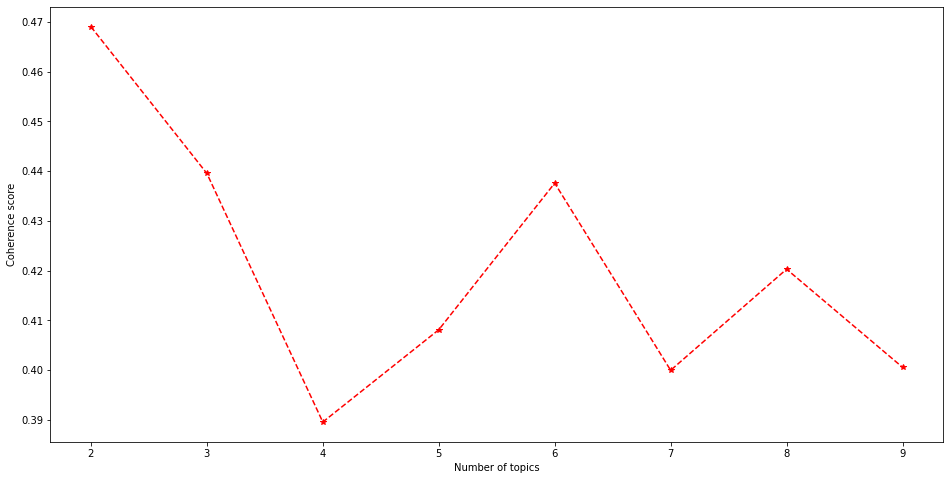

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (16,8))
plt.plot(topic_num,cv_score,color='RED', marker='*', linestyle='dashed')
plt.xticks(range(2,10))
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.show()

<h2> Dropping down number of topics for easy evaluation </h2>

In [ ]:
# Creating LDA model with number of topics as 2
Lda2 = gensim.models.ldamodel.LdaModel
ldamodel2 = Lda2(corpus=corpus,id2word=id2word,num_topics=2,random_state=100,update_every=1,chunksize=100,passes=10,alpha="auto")
clear_output()

In [ ]:
print(CoherenceModel(model=ldamodel2,texts=df['cleaned_text2'],dictionary=id2word , coherence='c_v').get_coherence())

0.45748796567432415


In [ ]:
ldamodel2.print_topics()

[(0,
  '0.010*"people" + 0.010*"child" + 0.009*"sexual" + 0.005*"right" + 0.005*"amp" + 0.005*"com" + 0.005*"time" + 0.005*"year" + 0.005*"feel" + 0.005*"can"'),
 (1,
  '0.010*"twitter" + 0.008*"say" + 0.007*"child" + 0.007*"com" + 0.007*"sexual" + 0.006*"survivor" + 0.006*"know" + 0.006*"people" + 0.005*"amp" + 0.005*"call"')]

In [ ]:
vis2 = gensim_models.prepare(ldamodel2, corpus, id2word, mds="mmds", R=30)
vis2

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.003477 -0.061358       1        1  51.719812
0      0.003477  0.061358       2        1  48.280188, topic_info=       Term      Freq     Total Category  logprob  loglift
333    know  5.000000  5.000000  Default  30.0000  30.0000
141    year  3.000000  3.000000  Default  29.0000  29.0000
189  public  3.000000  3.000000  Default  28.0000  28.0000
144    girl  3.000000  3.000000  Default  27.0000  27.0000
145  guilty  3.000000  3.000000  Default  26.0000  26.0000
..      ...       ...       ...      ...      ...      ...
115    just  2.827910  5.066173   Topic2  -5.5848   0.1451
246  should  2.806783  5.066680   Topic2  -5.5923   0.1375
21    other  2.814949  6.349993   Topic2  -5.5893  -0.0854
119    want  2.822764  6.991559   Topic2  -5.5866  -0.1788
44      say  2.814233  8.917027   Topic2  -5.5896  -0.4251

[144 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
9         1  0.781454   actually
578       1  0.781414      again
681       1  0.781428        age
50        2  0.795347    alcohol
51        1  0.485111        amp
...     ...       ...        ...
361       2  0.393570      woman
499       2  0.795400       work
256       1  0.781430     worker
141       2  0.796189       year
171       2  1.059479  yesterday

[150 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [ ]:
# Creating a lookup table for topics
topic_data = pd.DataFrame((ldamodel2.print_topics()),columns=['TopicNumber','TopKeywords'])
topic_data['TopicName'] = ['child amp', 'survival'] #enter selected topics names here
topic_data = topic_data[['TopicNumber','TopicName','TopKeywords']]
topic_data['TopKeywords'] = topic_data.TopKeywords.str.replace(r'[^a-z]',' ',regex=True).apply(lambda x: x.split())
topic_data.style.set_properties(subset=['TopKeywords'], **{'width': '300px'}) #space between columns

,TopicNumber,TopicName,TopKeywords
0,0,child amp,"['people', 'child', 'sexual', 'right', 'amp', 'com', 'time', 'year', 'feel', 'can']"
1,1,survival,"['twitter', 'say', 'child', 'com', 'sexual', 'survivor', 'know', 'people', 'amp', 'call']"


In [ ]:
df.isnull().sum()

url                  0
date                 0
content              0
renderedContent      0
user                 0
replyCount           0
retweetCount         0
likeCount            0
quoteCount           0
lang                 0
outlinks            76
tcooutlinks         76
media               93
retweetedTweet     100
quotedTweet         85
coordinates          0
place                0
cleaned_text         0
cleaned_text1        0
cleaned_text2        0
LabelFromVADER       0
dtype: int64

In [ ]:
#Creating new columns and inserting topic numbers and names
for y,sent in enumerate(ldamodel2[corpus]):
  topic_num =[]
  topic_details = sorted(sent,key=lambda x: x[1], reverse=True)[:2] # Getting top 2 topics in descending order
  topic_num.append(topic_details[0][0]) # Appending top topic
  if len(topic_details) > 1:
    if topic_details[1][1] > 0.35: # Appending second topic only if it has more than 35% influence on current row
      topic_num.append(topic_details[1][0])
  df.loc[y,'TopicNumber'] = ','.join(str(x) for x in sorted(topic_num))

In [ ]:
#df.dropna(inplace = True)

In [ ]:
for index,topic_num in enumerate(df.TopicNumber):
  topic_name_list=[]
  for single_topic_num in (topic_num).split(','):
    single_topic_num=int(single_topic_num)
    topic_name_list.append(topic_data.loc[topic_data.TopicNumber == single_topic_num,'TopicName'][single_topic_num])
  # Extracting topic names from lookup table
  df.loc[index,'TopicName'] =' & '.join(topic_name_list)

In [ ]:
df.head()

,url,date,content,renderedContent,user,replyCount,retweetCount,likeCount,quoteCount,lang,outlinks,tcooutlinks,media,retweetedTweet,quotedTweet,coordinates,place,cleaned_text,cleaned_text1,cleaned_text2,LabelFromVADER,TopicNumber,TopicName
0,https://twitter.com/martyps/status/14766877858...,2021-12-30 22:52:58+00:00,@TrakkyD @NSWHealth abuse was hurled at scient...,@TrakkyD @NSWHealth abuse was hurled at scient...,"{'username': 'martyps', 'id': 17335098, 'displ...",0,0,0,0,en,NaN,NaN,NaN,NaN,NaN,"{'longitude': 150.520928608, 'latitude': -34.1...","{'fullName': 'Sydney, New South Wales', 'name'...",trakkyd nswhealth abuse was hurled at scienti...,trakkyd abuse hurl scientist much more knowled...,"[trakkyd, abuse, hurl, scientist, much, more, ...",neg,0,child amp
1,https://twitter.com/AlliC19/status/14766814294...,2021-12-30 22:27:42+00:00,@crakeka1 It is interesting as many attack oth...,@crakeka1 It is interesting as many attack oth...,"{'username': 'AlliC19', 'id': 1903049988, 'dis...",1,0,1,0,en,NaN,NaN,NaN,NaN,NaN,"{'longitude': 144.593741856, 'latitude': -38.4...","{'fullName': 'Melbourne, Victoria', 'name': 'M...",crakeka1 it is interesting as many attack oth...,crakeka1 interesting many attack other politic...,"[crakeka, interesting, many, attack, other, po...",neg,1,survival
2,https://twitter.com/mikjcal/status/14766793839...,2021-12-30 22:19:35+00:00,@chadfelixg No wonder LGBTQ would feel mentall...,@chadfelixg No wonder LGBTQ would feel mentall...,"{'username': 'mikjcal', 'id': 8096509038001561...",0,0,1,0,en,NaN,NaN,NaN,NaN,NaN,"{'longitude': 144.593741856, 'latitude': -38.4...","{'fullName': 'Melbourne, Victoria', 'name': 'M...",chadfelixg no wonder lgbtq would feel mentall...,wonder would feel mentally fuke when re hate w...,"[wonder, would, feel, mentally, fuke, when, re...",neg,1,survival
3,https://twitter.com/AweCentiQue/status/1476483...,2021-12-30 09:20:47+00:00,@thesayno7 @Anne_Ruston @JElliotMP @JulianHill...,@thesayno7 @Anne_Ruston @JElliotMP @JulianHill...,"{'username': 'AweCentiQue', 'id': 140039824775...",0,1,1,0,en,NaN,NaN,NaN,NaN,NaN,"{'longitude': 152.668522848, 'latitude': -27.7...","{'fullName': 'Brisbane, Queensland', 'name': '...",thesayno7 anne ruston jelliotmp julianhillmp ...,thesayno7 immoral act claim sexual assault inf...,"[thesayno, immoral, act, claim, sexual, assaul...",neg,0,child amp
4,https://twitter.com/Kuvlotik/status/1476424899...,2021-12-30 05:28:21+00:00,@marie19705 @ScottMorrisonMP 2/\ndivides inste...,@marie19705 @ScottMorrisonMP 2/\ndivides inste...,"{'username': 'Kuvlotik', 'id': 93730228, 'disp...",1,0,1,0,en,NaN,NaN,NaN,NaN,NaN,"{'longitude': 151.468376, 'latitude': -30.6589...","{'fullName': 'Uralla, New South Wales', 'name'...",marie19705 scottmorrisonmp 2 divides instead ...,scottmorrisonmp divide instead unify go missin...,"[scottmorrisonmp, divide, instead, unify, go, ...",neg,0,child amp


In [ ]:
#df.dropna(inplace = True)


In [ ]:
range(df.shape[0])

range(0, 100)

In [ ]:
df['label'] = df.TopicName.str.cat(df.LabelFromVADER, sep='_')

In [ ]:
df['label'] = df['label'].str.replace('information_data_neg', 'accident_event_neg')
df['label'] = df['label'].str.replace('accident_event_data_neg', 'information_neg')

In [ ]:
df.label.unique()

array(['child amp_neg', 'survival_neg', 'child amp_pos'], dtype=object)

In [ ]:
for i in df[df.label == 'accident_event_data & information_data_pos']['renderedContent'][:20]:
  print(i)
  print()

In [ ]:
df.to_csv('Tweets_with_Labels.csv')